<h1>Preliminaries</h1>
<p>This codebase was originally created at Facebook by the team behind the following paper:</p>
<p><strong>Radioactive data: tracing through training</strong><br />
    <a href="https://arxiv.org/pdf/2002.00937.pdf">https://arxiv.org/pdf/2002.00937.pdf</a>
        </p>
    
<p>We have made some quality of life changes and created this notebook to help others learn faster. The demonstration
will: </p>
   <ol>
       <li>Mark a certain subset of the CIFAR10 dataset (target data) using a resnet18 pretrained on imagenet (marking network)</li>
       <li>Use the modified CIFAR10 dataset to train a new resnet18 (target network)</li>
       <li>Attempt to detect radioactivity in the target network</li>
    </ol>
</p>
<p><strong>Note:</strong><br/>
In our example the marking network is pretrained on imagenet, while our target data is CIFAR10.
According to section 5.5 of the paper, even a marking network trained on a different
data distribution will output radioactive markings that are useful when applied to at least 10% of the dataset. 
This number could vary, we are just quoting the minimum radioactive data percentage shown in the paper. </p>
<p>If the marking network was trained on the same data distribution it is likely that a lower percentage of the
   target data would require marking to achieve the same p value in the detection stage.</p>

<h1>Creating Radioactive Data (Image Marking)</h1>

<h2>Prepare Dataset</h2>
<p>First we download the CIFAR10 dataset which has 10 classes.</p>
<p>Then we randomly choose an image class and sample a certain percentage of the images for saving to "img/data".</p>
<p>After saving these images to "img/data" we also save a list of image paths to pass into <em>make_data_radioactive.py</em>.</p>
<p>Currently <em>make_data_radioactive.py</em> doesn't support multi-class, so we only sample from a chosen class of images.</p>

In [160]:
import torchvision
import torch
import random
import PIL
import os
import shutil
import tqdm

target_data_classes = 10 # 10 for CIFAR10 data

# Download CIFAR10 dataset
train_set = torchvision.datasets.CIFAR10(root="data/datasets", download=True)

# Index images by class
images_by_class = []
for x in range(0, target_data_classes):
    images_by_class.append([])

for index, (img, label) in enumerate(train_set):
    images_by_class[label].append(index)

# Randomly choose an image class
chosen_image_class = random.choice(list(range(0, target_data_classes)))
print(f"Randomly selected image class {chosen_image_class} ({train_set.classes[chosen_image_class]})", flush=True)

# Randomly sample images from that class
data_marking_percentage = 1
total_marked_in_class = int(len(images_by_class[chosen_image_class]) * (data_marking_percentage / 100))
train_marked_indexes = random.sample(images_by_class[chosen_image_class], total_marked_in_class)

# Save these images for marking to /data/img and build list file
image_dir_path = "data/img"
shutil.rmtree(image_dir_path, ignore_errors=True)
os.makedirs(image_dir_path)

print(f"Saving {total_marked_in_class} images randomly sampled from class.", flush=True)
image_list = []
for i in tqdm.tqdm(train_marked_indexes):
    image, _ = train_set[i]
    image_path = f"{image_dir_path}/train_{i}.png"
    with open(image_path, 'wb') as fh:
        img = image.save(fh)
    image_list.append(image_path)
     
train_image_list_path = "data/train_img_list.txt"
torch.save(image_list, train_image_list_path)

Files already downloaded and verified
Randomly selected image class 5 (dog)
Saving 50 images randomly sampled from class.


100%|████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1134.97it/s]


<h2>Download Marking Network And Save For Later</h2>
<p>The below confused me at first. All <em>make_data_radioactive.py</em> is doing is spooling up a new
torchvision.models.[architecture](marking_network_classes) and loading the state dictionary from the pretrained model, in
this case trained on ImageNet with 1000 classes. After this occurs the fully connected layer is just removed anyway.
</p>

In [161]:
import torch
from torchvision import models

marking_network_output_dim_pre_classifier = 512 # Used Further On
marking_network_classes = 1000

resnet18 = models.resnet18(pretrained=True)
torch.save({
    "model": resnet18.state_dict(),
    "params": {
      "architecture": "resnet18",
      "num_classes": marking_network_classes,
    }
  }, "data/pretrained_resnet18.pth")
print("Marking network saved")

Marking network saved


<h2>Create Random Carriers</h2>
<p>Generates a random array of shape (target_data_classes, marking_network_output_dim_pre_classifier). 
In terms of the paper, this would be a concatenation of a random vector u for each class, see section 3 for details. The code in <em>make_data_radioactive.py</em> currently doesn't support multi-class, so it just slices this array to get a single random u.</p>

In [162]:
import torch

carriers = torch.randn(target_data_classes, marking_network_output_dim_pre_classifier)
carriers /= torch.norm(carriers, dim=1, keepdim=True)
print("Carrier Shape:", carriers.shape)
torch.save(carriers, "data/carriers.pth")

Carrier Shape: torch.Size([10, 512])


<h2>Run make_data_radioactive.py</h2>
<p>The original code used input parameters but I have converted this to a config file out of taste preference.</p>
<p><strong>img_list</strong> must be the same as <strong>train_image_list_path</strong> above</p> <br/><strong>carrier_id</strong> is irrelevant as multi-class is not currently supported, by setting it to 0 we just grab the first random u vector out of the carriers array created above.

<p>Training (marking) will take about 10 minutes for 50 CIFAR images on a quad core CPU @ 4ghz. GPU would be way faster.</p>

In [163]:
import shutil

# Clear the experiment directory
dump_path = "data/dump"
shutil.rmtree(dump_path, ignore_errors=True)

In [164]:
%%writefile config_make_radioactive.toml
dump_path = "data/dump"
exp_name = "bypass"
exp_id = ""
img_size = 256
crop_size = 224
data_augmentation = "random"
radius = 10
epochs = 90
lambda_ft_l2 = 0.01
lambda_l2_img = 0.0005
optimizer = "sgd,lr=1.0"
carrier_path = "data/carriers.pth"
carrier_id = 0
half_cone = true
img_list = "data/train_img_list.txt"
img_paths = ":"
marking_network = "data/pretrained_resnet18.pth"
debug_train = false
debug_slurm = false
debug = false
batch_size = 50


Overwriting config_make_radioactive.toml


In [165]:
%run make_data_radioactive.py

INFO - 08/29/20 07:25:18 - 0:00:00 - ============ Initialized logger ============
INFO - 08/29/20 07:25:18 - 0:00:00 - angle: None
                                     batch_size: 50
                                     carrier_id: 0
                                     carrier_path: data/carriers.pth
                                     command: python make_data_radioactive.py --exp_id "dump"
                                     crop_size: 224
                                     data_augmentation: random
                                     debug: False
                                     debug_slurm: False
                                     debug_train: False
                                     dump_path: data\dump
                                     epochs: 90
                                     exp_id: dump
                                     exp_name: bypass
                                     half_cone: True
                                     img_list: data/train_img_l

INFO - 08/29/20 07:27:00 - 0:01:42 - Augmenting images
INFO - 08/29/20 07:27:06 - 0:01:48 - __log__:{"keyword": "iteration", "loss": -61.093997955322266, "loss_ft": -70.91851806640625, "loss_norm": 0.9437875151634216, "loss_ft_l2": 8.88073444366455}
INFO - 08/29/20 07:27:06 - 0:01:48 - Augmenting images
INFO - 08/29/20 07:27:13 - 0:01:55 - __log__:{"keyword": "iteration", "loss": -59.01100540161133, "loss_ft": -68.97290802001953, "loss_norm": 0.9615516662597656, "loss_ft_l2": 9.000346183776855}
INFO - 08/29/20 07:27:13 - 0:01:55 - Augmenting images
INFO - 08/29/20 07:27:20 - 0:02:01 - __log__:{"keyword": "iteration", "loss": -58.30083465576172, "loss_ft": -68.22317504882812, "loss_norm": 0.9763237237930298, "loss_ft_l2": 8.946013450622559}
INFO - 08/29/20 07:27:20 - 0:02:01 - Augmenting images
INFO - 08/29/20 07:27:27 - 0:02:08 - __log__:{"keyword": "iteration", "loss": -52.70465087890625, "loss_ft": -62.89706039428711, "loss_norm": 0.9871989488601685, "loss_ft_l2": 9.205209732055664}


INFO - 08/29/20 07:30:34 - 0:05:15 - Augmenting images
INFO - 08/29/20 07:30:40 - 0:05:22 - __log__:{"keyword": "iteration", "loss": -68.0633316040039, "loss_ft": -78.29290008544922, "loss_norm": 1.1179983615875244, "loss_ft_l2": 9.111574172973633}
INFO - 08/29/20 07:30:40 - 0:05:22 - Augmenting images
INFO - 08/29/20 07:30:47 - 0:05:28 - __log__:{"keyword": "iteration", "loss": -86.15574645996094, "loss_ft": -96.28007507324219, "loss_norm": 1.120911955833435, "loss_ft_l2": 9.003414154052734}
INFO - 08/29/20 07:30:47 - 0:05:28 - Augmenting images
INFO - 08/29/20 07:30:53 - 0:05:35 - __log__:{"keyword": "iteration", "loss": -74.61319732666016, "loss_ft": -84.78508758544922, "loss_norm": 1.1171156167984009, "loss_ft_l2": 9.054769515991211}
INFO - 08/29/20 07:30:53 - 0:05:35 - Augmenting images
INFO - 08/29/20 07:31:00 - 0:05:41 - __log__:{"keyword": "iteration", "loss": -86.4424057006836, "loss_ft": -96.78111267089844, "loss_norm": 1.123899221420288, "loss_ft_l2": 9.214808464050293}
INFO

INFO - 08/29/20 07:34:02 - 0:08:44 - Augmenting images
INFO - 08/29/20 07:34:09 - 0:08:50 - __log__:{"keyword": "iteration", "loss": -80.16462707519531, "loss_ft": -90.552001953125, "loss_norm": 1.1544820070266724, "loss_ft_l2": 9.232898712158203}
INFO - 08/29/20 07:34:09 - 0:08:50 - Augmenting images
INFO - 08/29/20 07:34:14 - 0:08:56 - __log__:{"keyword": "iteration", "loss": -71.56205749511719, "loss_ft": -81.89144897460938, "loss_norm": 1.1585023403167725, "loss_ft_l2": 9.17088794708252}
INFO - 08/29/20 07:34:14 - 0:08:56 - Augmenting images
INFO - 08/29/20 07:34:21 - 0:09:03 - __log__:{"keyword": "iteration", "loss": -66.34880065917969, "loss_ft": -76.90263366699219, "loss_norm": 1.1558021306991577, "loss_ft_l2": 9.398033142089844}
INFO - 08/29/20 07:34:21 - 0:09:03 - Augmenting images
INFO - 08/29/20 07:34:28 - 0:09:10 - __log__:{"keyword": "iteration", "loss": -74.13954162597656, "loss_ft": -84.4522476196289, "loss_norm": 1.1586270332336426, "loss_ft_l2": 9.154074668884277}
INFO

<h2>Inspect Our New Images</h2>

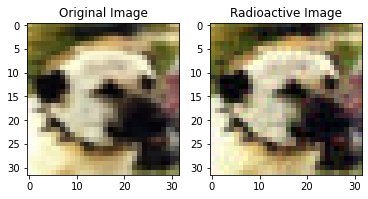

In [166]:
import torch
import numpy as np
import PIL
from matplotlib import pyplot as plt
import glob
import random
import os

def loadImageRGB(path):
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')
    
radioactive_images = glob.glob('data/dump/*.npy')
radioactive_image_path = random.choice(radioactive_images)
original_image_path = f"data/img/{os.path.basename(radioactive_image_path)}".replace("npy", "png")

original_img = loadImageRGB(original_image_path)
radioactive_img = np.load(radioactive_image_path)

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(original_img)
ax1.set_title("Original Image")
ax2.imshow(radioactive_img)
ax2.set_title("Radioactive Image")
plt.show()


<h1>Training A Model</h1>
<p>Work in progress...</p>

In [ ]:
import torch
import glob
import re

radioactive_image_paths = glob.glob('data/dump/*.npy')

#search using regex
content = {}
for path in radioactive_image_paths:
    img_id = re.search('[0-9]+', path)
    content[img_id[0]] = path 

torch.save({
  'type': 'per_sample',
  'content': content
}, "data/radioactive_data.pth")
print("Radioactive image paths saved")

In [ ]:
%%writefile config_train_classif.toml
dump_path = "data/dump"
exp_name = "bypass"
save_periodic = 0
exp_id = ""
nb_workers = 10
fp16 = false
dataset = "cifar10"
num_classes = -1
architecture = "resnet18"
non_linearity = "relu"
pretrained = false
from_ckpt = ""
load_linear = false
train_path = "radioactive_data.pth"
optimizer = "sgd,lr=0.1-0.01-0.001,momentum=0.9,weight_decay=0.0001"
batch_size = 256
epochs = 90
stopping_criterion = ""
validation_metrics = ""
train_transform = "random"
seed = 0
only_train_linear = false
reload_model = ""
eval_only = false
debug_train = false
debug_slurm = false
debug = true
local_rank = -1
master_port = -1
use_cpu = true


In [ ]:
%run train-classif.py